# 趋势检验

Mann-Kendall趋势检验

$$
S=\sum_{i=1}^{n-1} \sum_{j=i+1}^{n} \operatorname{sgn}\left(x_{j}-x_{i}\right)
$$

* 如果S为正，则后面的观测值大于前面的观测值。
* 如果S为负，则后面的观测值小于前面的观测值。

In [15]:
import numpy as np
from scipy.stats import norm

x = np.array([23, 24, 29, 6, 29, 24, 24, 29, 23])
n = len(x)
def calculate_S(x):
    
    # 计算S
    S = 0
    n = len(x)
    for i in range(n-1):
        for j in range(i+1, n):
            S += np.sign(x[j] - x[i])
    return S
S = calculate_S(x)
print('S=', S)

S= 3


## Tied Group

计算tied group数（具有相同值的数据组的个数），也即计算出现次数超过1次的值的个数

In [16]:
# np.unique函数可返回数组中独特元素，以及独特元素出现次数
unique_x, tp = np.unique(x, return_counts=True)
g = len(unique_x)
print(unique_x)
print(tp) # 注意：这里tp中出现1，即‘6’出现1次。按照定义不能计入tied group，但是按照下式计算时，对Var无影响。

[ 6 23 24 29]
[1 2 3 3]


## 计算$\operatorname{Var}(S)$及$Z$
$$
\operatorname{Var}(S)=\frac{n(n-1)(2 n+5)-\sum_{p=1}^{g} t_{p}\left(t_{p}-1\right)\left(2 t_{p}+5\right)}{18}
$$

$$
Z_{c}=\left\{\begin{array}{l}
\frac{S-1}{\sqrt{\operatorname{Var}(S)}}, S>0 \\
0, \quad S=0 \\
\frac{S+1}{\sqrt{\operatorname{Var}(S)}}, S<0
\end{array}\right.
$$

norm是正态分布函数
$$
f(x)=\frac{\exp \left(-x^{2} / 2\right)}{\sqrt{2 \pi}}
$$

In [19]:
# 计算Var以及z
Var_S = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

if S > 0:
    Z = (S - 1)/np.sqrt(Var_S)
elif S < 0:
    Z = (S + 1)/np.sqrt(Var_S)
else: # s == 0:
    Z = 0
 
print('Var(S)=', Var_S)
print('Z=', Z)

Var(S)= 83.66666666666667
Z= 0.2186521551237011


In [23]:
# 下面进行置信度检验
alpha = 0.05
# 计算p值
p = 2*(1-norm.cdf(abs(Z)))  # two tail test

h = abs(Z) > norm.ppf(1-alpha/2) # ppf: Percent point function (inverse of cdf — percentiles). 即根据p反算临界Z

if (Z < 0) and h:
    trend = 'decreasing'
elif (Z > 0) and h:
    trend = 'increasing'
else:
    trend = 'no trend'

print('p=', p)
print('Z临界值=', norm.ppf(1-alpha/2))
print(trend)

p= 0.8269210217567053
Z临界值= 1.959963984540054
no trend


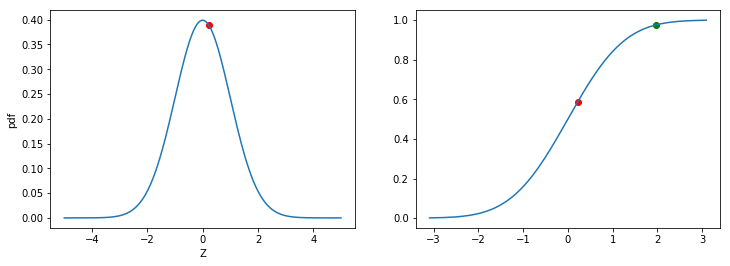

In [61]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=[12,4])
ax1 = axs[0]
z_ser = np.linspace(-5, 5, 1000)
p_ser = norm.pdf(z_ser)
ax1.plot(z_ser, p_ser)
ax1.set_xlabel('Z')
ax1.set_ylabel('pdf')
ax1.scatter(Z, norm.pdf(abs(Z)), color='red')
ax2 = axs[1]

p_ser = np.linspace(0, 1, 1000)
z_ser = norm.ppf(p_ser)
ax2.plot(z_ser, p_ser)
ax2.scatter(norm.ppf(1-alpha/2), 1-alpha/2, color='green')
ax2.scatter(Z, norm.cdf(Z), color='red')
plt.show()

# 变点检验

Mann-Kendall变点检验

$$s_{k}=\sum_{i=1}^{k} r_{i}, k=2,3, \dots, n$$
$$
r_{i}=\left\{\begin{array}{ll}
+1, & x_{i}>x_{j} \\
+0, & x_{i} \leq x_{j}, j=1,2, \dots, i
\end{array}\right.
$$
$s_k$为第$i$个时刻数值大于$j$时刻数值个数的累计。

$$
\operatorname{Var}\left(s_{k}\right)=k(k-1)(2 k+5) / 72
$$

$$
U F_{k}=\frac{s_{k}-E\left(s_{k}\right)}{\sqrt{\operatorname{Var}\left(s_{k}\right)}}
$$

构造逆序时间序列，计算新的${{UF}'_k}$
$$
U B_{k}=-{UF}'_{k}
$$

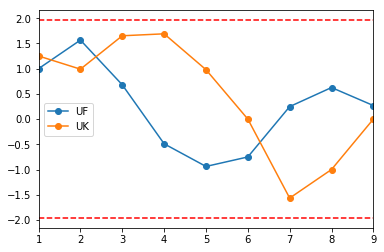

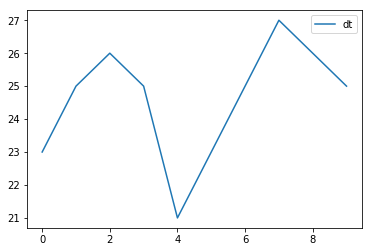

In [77]:
import numpy as np

def Kendall_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n=inputdata.shape[0]
    # 正序列计算---------------------------------
    # 定义累计量序列Sk，初始值=0
    Sk             = [0]
    # 定义统计量UFk，初始值 =0
    UFk            = [0]
    # 定义Sk序列元素s，初始值 =0
    s              =  0
    Exp_value      = [0]
    Var_value      = [0]
    # i从1开始，因为根据统计量UFk公式，i=0时，Sk(0)、E(0)、Var(0)均为0
    # 此时UFk无意义，因此公式中，令UFk(0)=0
    for i in range(1,n):
        for j in range(i):
            if inputdata[i] > inputdata[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        Exp_value.append(i*(i+1)/4)                     # Sk[i]的均值
        Var_value.append((i+1)*i*(2*(i+1)+5)/72)            # Sk[i]的方差
        UFk.append((Sk[i]-Exp_value[i])/np.sqrt(Var_value[i]))
    # ------------------------------正序列计算
    
    # 逆序列计算---------------------------------
    # 定义逆序累计量序列Sk2，长度与inputdata一致，初始值=0
    Sk2             = [0]
    # 定义逆序统计量UBk，长度与inputdata一致，初始值=0
    UBk             = [0]
    UBk2            = [0]
    # s归0
    s2              =  0
    Exp_value2      = [0]
    Var_value2      = [0]
    # 按时间序列逆转样本y
    inputdataT = list(reversed(inputdata))
    # i从2开始，因为根据统计量UBk公式，i=1时，Sk2(1)、E(1)、Var(1)均为0
    # 此时UBk无意义，因此公式中，令UBk(1)=0
    for i in range(1,n):
        for j in range(i):
            if inputdataT[i] > inputdataT[j]:
                s2 = s2+1
            else:
                s2 = s2+0
        Sk2.append(s2)
        Exp_value2.append(i*(i+1)/4)                     # Sk[i]的均值
        Var_value2.append((i+1)*i*(2*(i+1)+5)/72)            # Sk[i]的方差
        UBk.append((Sk2[i]-Exp_value2[i])/np.sqrt(Var_value2[i]))
        UBk2.append(-UBk[i])
    UBkT = list(reversed(UBk2))
    diff = np.array(UFk) - np.array(UBkT)
    K    = list()
    # 找出交叉点
    for k in range(1,n):
        if diff[k-1]*diff[k]<0:
            K.append(k)
            
    # 绘图：UF及UB
    plt.figure()
    plt.plot(UFk, 'o-', label='UF')
    plt.plot(UBkT, 'o-', label='UK')
    # 画临界线1.96
    plt.plot(np.ones_like(UFk)*1.96, 'r--')
    plt.plot(-np.ones_like(UFk)*1.96, 'r--')
    plt.legend()
    plt.xlim([1, 9])
    plt.show()
    return K, Sk, Sk2, Exp_value, Var_value
dt = [23, 25, 26, 25, 21, 23, 25, 27, 26, 25]
Kendall_change_point_detection(dt)

plt.figure()
plt.plot(dt, label='dt')
plt.legend()
plt.show()

# Pettitt变点检验

$$
U_{t, T}=\sum_{i=1}^{t} \sum_{j=t+1}^{T} \operatorname{sgn}\left(x_{j}-x_{i}\right)
$$

𝑇为样本总个数。𝑈_(𝑡, 𝑇)即为前𝑡个样本中，大于后𝑛−𝑡个样本中的个数统计(大于+1，小于-1)。

$$
K_{T}=\max _{1 \leq t \leq T}\left|U_{t, T}\right| \quad p=2 \exp \left(\frac{-6 K_{T}^{2}}{T^{3}+T^{2}}\right)
$$

1−𝑝为该序列存在变点的置信度。

In [79]:
import numpy as np

def Pettitt_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n         = inputdata.shape[0]
    Uk = np.zeros(n)
    for t in range(1, n+1):
        r = 0
        for i in range(1, t+1):
            for j in range(t+1, n+1):
                r += np.sign(inputdata[i-1]-inputdata[j-1])
        Uk[t-1] = r
    Uka = list(np.abs(Uk))
    U = np.max(Uka)
    K = Uka.index(U)
    pvalue = 2 * np.exp((-6 * (U**2))/(n**3 + n**2))
    if pvalue <= 0.05:
        change_point_desc = '显著'
    else:
        change_point_desc = '不显著'
    #Pettitt_result = {'突变点位置':K,'突变程度':change_point_desc}
    return K + 1, change_point_desc, Uk

In [80]:
dt = [23, 25, 26, 25, 21, 23, 25, 27, 26, 25]
#dt = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print("Pettitt:",Pettitt_change_point_detection(dt))

Pettitt: (6, '不显著', array([ -6.,  -6.,   0.,   0.,  -9., -15., -15.,  -6.,   0.,   0.]))


# 自回归

AR(1)

$$
X_{t}=\varphi_1 X_{t-1}+\varepsilon_{t}
$$

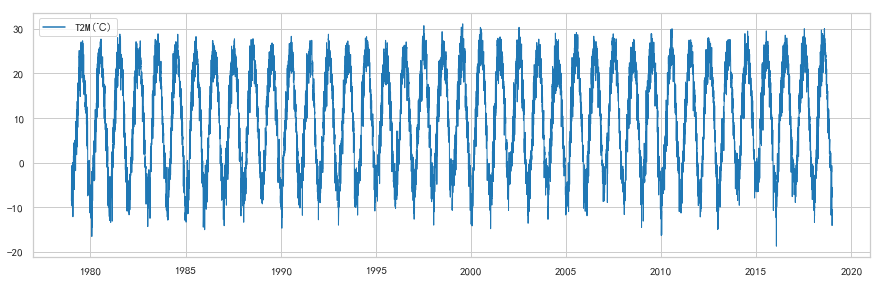

In [27]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = np.loadtxt('t2m_Beijing.txt')
days = len(data)//4
n_data = np.zeros(days)
index = np.arange(days)

for i in range(4):
    n_data += data[4*index + i]

n_data /= 4
n_data -= 273.15

plt.figure(figsize=(15, 4.5))
sns.set(style="whitegrid", font='SimHei')

dates = pd.date_range("1 1 1979", periods=days, freq="D")
pd_data = pd.DataFrame(n_data, dates, columns=["T2M(℃)"])
#data = data.rolling(365).mean()滑动平均

sns.lineplot(data=pd_data, palette="tab10", linewidth=1)

In [28]:
pd_data

,T2M(℃)
1979-01-01,-8.580161
1979-01-02,-6.095792
1979-01-03,-4.577475
1979-01-04,-3.151894
1979-01-05,-5.323118
1979-01-06,-1.792437
1979-01-07,-0.692478
1979-01-08,-0.870467
1979-01-09,-2.889900
1979-01-10,-4.780416
